#### In this notebook, we used data from Kermany (Retinal_OCT2017).

#### There are 4 classes AMD, DME, DRUSEN, NORMAL

We take all images from train and val sets and merge them and divide them into 80:20 split for train and val sets. We use the 1000 images from the test set as the test itself. Augmentations were done and training was done for 2 epochs using SGD optimizer on VGG16, performing transfer learning with pretrained frozen imagenet weights on convolutional layers while we retrain the classifier. After training we get 92% train and 92% val accuracy while getting 96% test set accuracy. We observe that white patches adds regularization to the images and forces the model to train of the key points to focus on. Transfer learning allows the model to learn and identify the key regions quickly allowing us to train better models in short amount of time

# Importing Data & Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
train_path = "/kaggle/input/kermany2018/OCT2017 /train"
val_path = "/kaggle/input/kermany2018/OCT2017 /val"
test_path = "/kaggle/input/kermany2018/OCT2017 /test"

# Data Pre Processing & Visualization

In [3]:
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

X_train = []
Y_train = []

for target in os.listdir(train_path):
    target_path = os.path.join(train_path, target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path, file)
        X_train.append(file_path)
        Y_train.append(target)

100%|██████████| 11348/11348 [00:00<00:00, 377522.96it/s]


In [4]:
for target in os.listdir(val_path):
    target_path = os.path.join(val_path, target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path, file)
        X_train.append(file_path)
        Y_train.append(target)

100%|██████████| 8/8 [00:00<00:00, 80273.76it/s]


In [5]:
X_test = []
Y_test = []

for target in os.listdir(test_path):
    target_path = os.path.join(test_path, target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path, file)
        X_test.append(file_path)
        Y_test.append(target)

100%|██████████| 242/242 [00:00<00:00, 337328.54it/s]


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

Training distribution

<AxesSubplot:ylabel='count'>

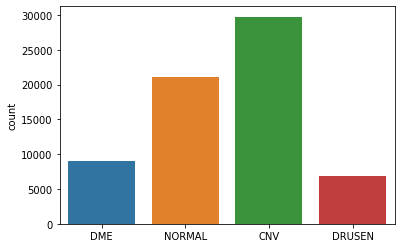

In [7]:
sns.countplot(x = Y_train)

Validation distribution

<AxesSubplot:ylabel='count'>

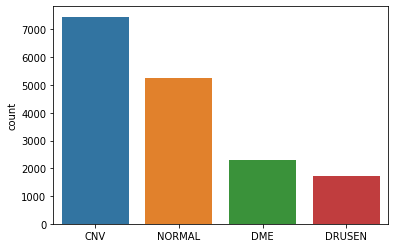

In [8]:
sns.countplot(x = Y_val)

Test distribution

<AxesSubplot:ylabel='count'>

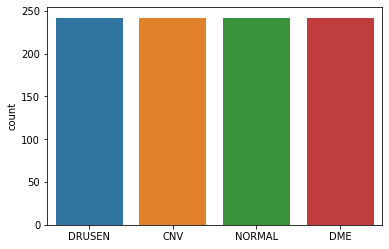

In [9]:
sns.countplot(x = Y_test)

In [10]:
df_train = pd.DataFrame(list(zip(X_train, Y_train)), columns =['image_path', 'label'])
df_val = pd.DataFrame(list(zip(X_val, Y_val)), columns =['image_path', 'label'])
df_test = pd.DataFrame(list(zip(X_test, Y_test)), columns =['image_path', 'label'])

## Data Augmentation

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_aug = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator= train_aug.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

val_generator= test_aug.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    color_mode="rgb",
    batch_size=16,
    shuffle = False, 
    target_size = (224, 224),
    class_mode="categorical")

Found 66812 validated image filenames belonging to 4 classes.
Found 16704 validated image filenames belonging to 4 classes.
Found 968 validated image filenames belonging to 4 classes.


# MODEL
## Compiling & Training

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D,AveragePooling2D, BatchNormalization, PReLU, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50, InceptionResNetV2

def generate_model(pretrained_model = 'vgg16', num_classes=4):
    if pretrained_model == 'inceptionv3':
        base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    elif pretrained_model == 'inceptionresnet':
        base_model = InceptionResNetV2(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3)) # Topless
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    #Freezing Convolutional Base
    for layer in base_model.layers[:-3]:
        layer.trainable = False  
    return model

In [13]:
def train_model(model, train_generator, test_generator, num_epochs, optimizer, metrics):
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=metrics)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6, verbose=1)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7)
    print(model.summary())
    
    history = model.fit(train_generator, epochs=num_epochs, 
                        validation_data=test_generator, verbose=1,
                        callbacks = [early_stop, rlr])
    
    return model, history

# Model Evaluation
## Plotting Curves - Loss, Accuracy, ROC + Confusion Matrix

In [14]:
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
# It prints & plots the confusion matrix, normalization can be applied by setting normalize=True.
    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(num_classes):
        fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        c_ax.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_labels[i], roc_auc[i]))
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
        c_ax.legend(loc="lower right")
        plt.show()
    return roc_auc_score(y_test, y_pred)

In [15]:
def evaluate_model(model, history, test_generator):
    # Evaluate model
    score = model.evaluate(test_generator, verbose=0)
    print('\nTest set accuracy:', score[1], '\n')
    
    y_true = np.array(test_generator.labels)
    y_pred = model.predict(test_generator, verbose = 1)
    y_pred_classes = np.argmax(y_pred,axis = 1)
    class_labels = list(test_generator.class_indices.keys())   
    
    print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = class_labels)
    plt.show()
    print("ROS AUC score:", plot_roc_curves(y_true, y_pred, 4, class_labels))

# Transfer Learning using VGG16

In [16]:
vgg_model = generate_model('vgg16', 4)

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
vgg_model, vgg_history = train_model(vgg_model, train_generator, val_generator, 2, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     


Test set accuracy: 0.96074378490448 

61/61 [==============================] - 5s 76ms/step

              precision    recall  f1-score   support

         CNV       0.89      1.00      0.94       242
         DME       1.00      0.98      0.99       242
      DRUSEN       1.00      0.87      0.93       242
      NORMAL       0.96      1.00      0.98       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968



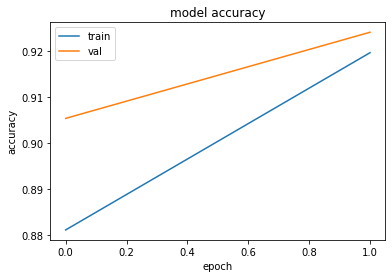

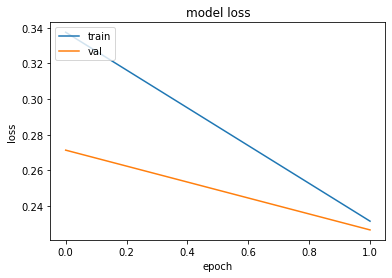

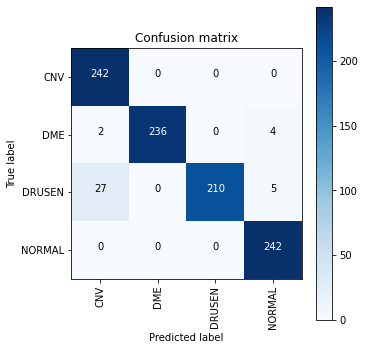

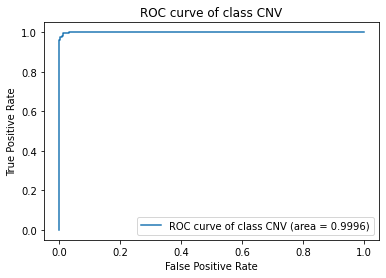

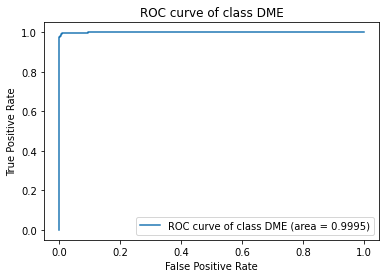

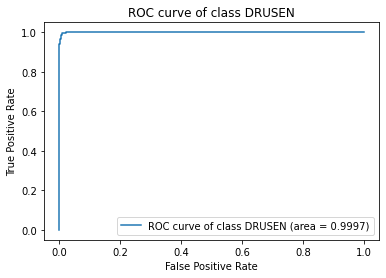

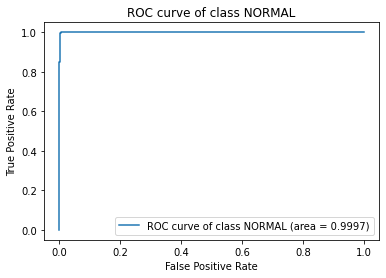

ROS AUC score: 0.9996172278760558


In [18]:
evaluate_model(vgg_model, vgg_history, test_generator)

In [19]:
vgg_model.save("/kaggle/working/model_weights.h5")